In [5]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Princeton Dropbox/Daniel Gurevich/Research/discrete_sr/code/SPIDER_discrete/src')

In [6]:
import numpy as np

from PySPIDER.commons.weight import *
from PySPIDER.commons.utils import save, load
from PySPIDER.discrete.library import *
from PySPIDER.discrete.process_library_terms import *

In [8]:
#data = np.load('LJ/positions_rho_0.30.npz')
#data = np.load('LJ/positions_rho_0.30_savefreq_5.npz')
data = np.load('LJ/positions_rho_0.30_savefreq_3.npz')

positions = data['positions'] 
vs = data['vs']
deltat = data['deltat']
dims = data['dims']

del data

print(positions.shape, vs.shape, deltat, dims)

Np, nt = positions.shape[0], positions.shape[2]
world_size = np.array([dims[0], dims[1], nt])

(9600, 2, 10000) (9600, 2, 10000) 2.539543411945013 [248.66604111 248.66604111]


0
0
0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200


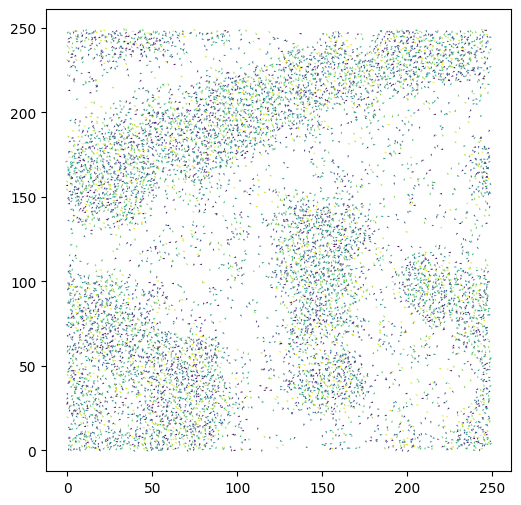

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'

vid_file = 'LJ/n9600rho0_30_savefreq_3.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [5]:
np.min(positions[:]), np.max(positions[:]), dims[0]

(np.float64(-2.334734546809943e-05),
 np.float64(248.66601395),
 np.float64(248.66604110734545))

In [9]:
%%prun # profiling

data_dict = {}
data_dict['v'] = vs
v_obs = Observable(string='v', rank=1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 20 #0.2
corr_T = 500
kernel_sigma = 4 # 0.02
cg_res = 1
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
rho_scale=Np/dims[0]/dims[1], irreps=SRDataset.all_rank2_irreps(), 
kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6, cache_primes=False)
#v_est = np.mean(np.abs(vs))*2**0.5
#print(v_est)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_rho=2)
srd.make_libraries(max_complexity=5, max_rho=2)
#srd.make_libraries(max_complexity=6, max_rho=2)
for irrep in srd.irreps:
    print(irrep, ":", len(srd.libs[irrep].terms))

dom_width = 100 # 0.1
dom_time = 200  # 50
#srd.make_domains(ndomains=10, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4)
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4)
#srd.make_domains(ndomains=100, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4)
srd.make_weights(m=8, qmax=1)
#srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
srd.set_LT_scale(L=corr_L, T=corr_T) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

Rank 0 : 42
Rank 1 : 50
Antisymmetric rank 2 : 14
Symmetric trace-free rank 2 : 34


KeyboardInterrupt: 

: 

In [47]:
from scipy.stats._stats import gaussian_kernel_estimate
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

def coarse_grain_slice(t, sigma, field='rho', component=None):
    pt_pos = positions[:, :, t]
    weights = np.ones(pt_pos.shape[0], dtype=np.float64)
    if field == 'v':
        weights *= vs[:, component, t]
    xx, yy = np.meshgrid(range(int(dims[0])), range(int(dims[1])))
    xi = np.vstack([xx.ravel(), yy.ravel()]).T

    sigma_sq = sigma ** 2
    # Check scipy version. If it's lower than 1.10, use inverse_covariance, otherwise use Cholesky
    if int(scipy.__version__.split(".")[0]) <= 1 and int(scipy.__version__.split(".")[1]) < 10:
        inv_cov = np.eye(2) / sigma_sq
    else:
        inv_cov = np.eye(2) * sigma_sq
        inv_cov = np.linalg.cholesky(inv_cov[::-1, ::-1]).T[::-1, ::-1]
    density = gaussian_kernel_estimate['double'](pt_pos, weights[:, None], xi, inv_cov,
                                                 np.float64)
    output = np.reshape(density[:, 0], xx.shape)
    return output

t = 3000
sigma = kernel_sigma * 1.5
rho_cg = coarse_grain_slice(t, sigma, field='rho')
vx_cg = coarse_grain_slice(t, sigma, field='v', component=0)
vy_cg = coarse_grain_slice(t, sigma, field='v', component=1)

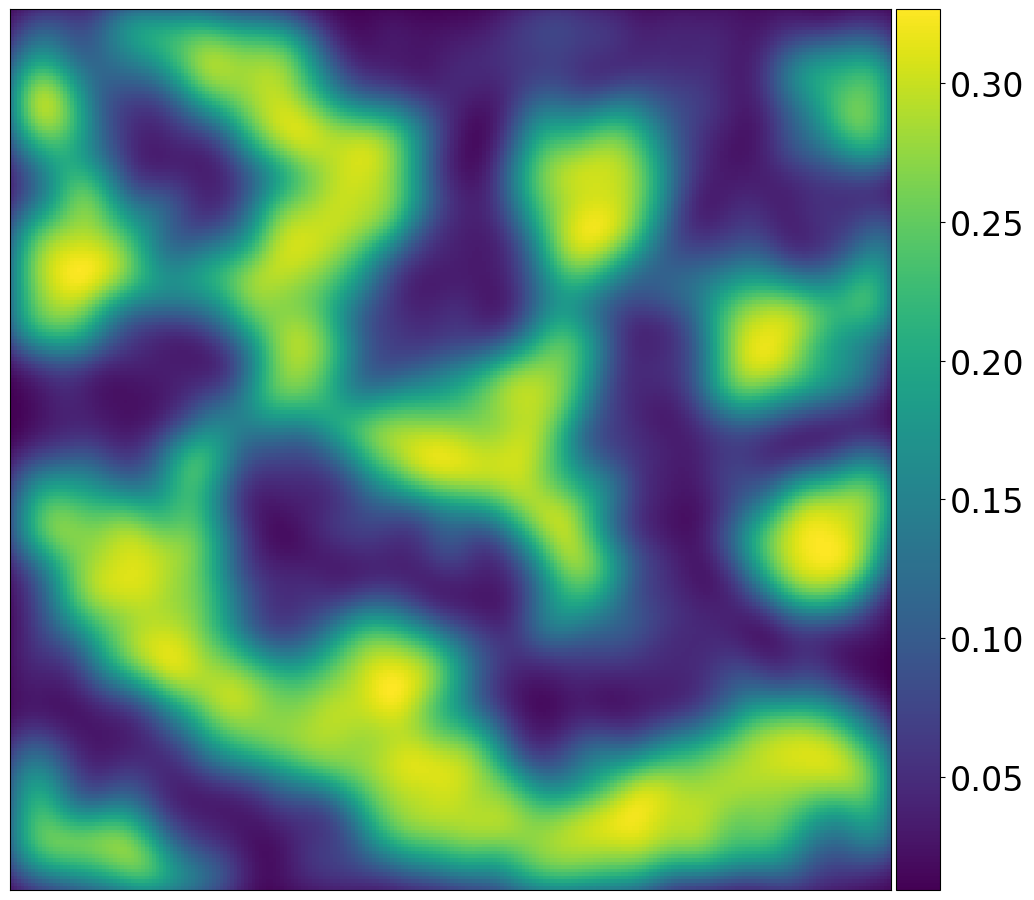

In [48]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
im1 = ax1.imshow(rho_cg)

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.ax.tick_params(labelsize=24) 

name = f'cg_rho_{sigma}.eps'
plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300,

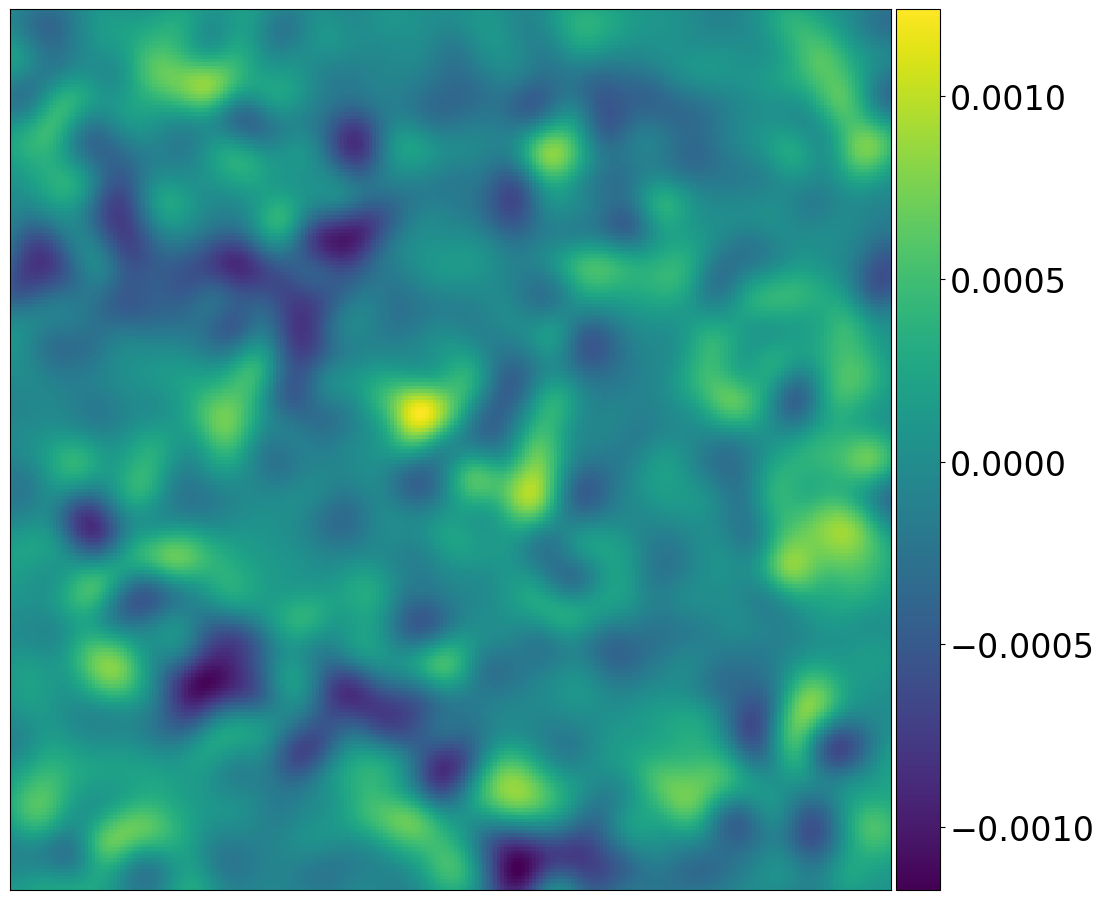

In [49]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
im1 = ax1.imshow(vx_cg)

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.ax.tick_params(labelsize=24) 

name = f'cg_vx_{sigma}.eps'
plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300,

In [40]:
from PySPIDER.commons.identify_models import *

libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    #print(np.linalg.norm(libs[irrep].Q, axis=0))
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=1)
    #init = Initializer(method='combinatorial', start_k=3)
    #init = Initializer(method='combinatorial', start_k=9999)
    init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    #res = Residual(residual_type='dominant_balance')
    #res = Residual(residual_type='matrix_relative')
    res = Residual(residual_type='hybrid')
    
    iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
    #iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)


eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
    #reg_opts_list, threshold=1e-6, experimental=True, report_accuracy=True,
    reg_opts_list, threshold=1e-1, experimental=True, report_accuracy=True,
    #print_opts={'num_format': '{0:.3g}', 'latex_output': True}
)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.02 s]
Identified model: 1 · ∂t ρ + ∂α ρ[v_α] = 0 (order 3, residual 8.57e-06)
(r_h = 8.57e-06)
[0.39 s]
Identified model: -0.000524 · ρ + ρ[v_α · v_α] = 0 (order 3, residual 6.64e-02)
(r_h = 6.64e-02)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Symmetr

[1.254e-02 2.828e-07 1.630e-07 1.108e-07 9.401e-08 9.050e-08 8.884e-08
 8.698e-08 8.633e-08 8.601e-08]
(np.float64(1.0), np.float64(0.08821962874143316), np.float64(0.9999987871897162))
[ρ · ∂t ρ, ρ · ∂α ρ[v_α], ∂t ρ, ∂t³ ρ, ∂α ρ[v_α]]
∂t ρ + 0.0882 · ∂t³ ρ + 1 · ∂α ρ[v_α] = 0


/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel_26410/3217646527.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


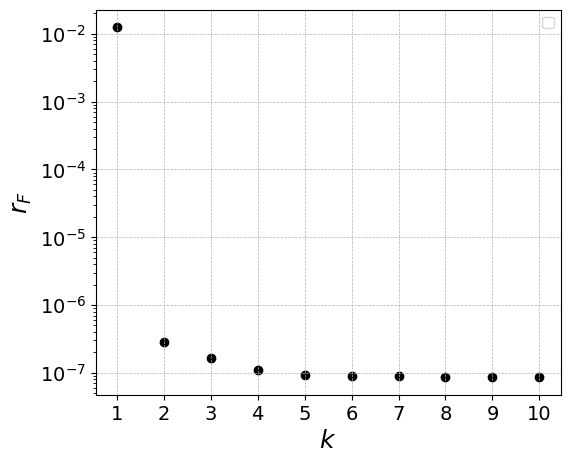

[2.000e-03 4.510e-08 2.600e-08 1.768e-08 1.740e-08 1.731e-08 1.729e-08
 1.723e-08 1.722e-08 1.722e-08]
(np.float64(1.0), np.float64(0.9999987869714075), np.float64(-0.0882233522055046))
[ρ · ∂t ρ, ρ · ∂α ρ[v_α], ∂t ρ, ∂t ρ · ∂α ρ[v_α], ∂α ρ[v_α]]
∂t ρ + 1 · ∂α ρ[v_α] + -0.0882 · ∂t² ∂α ρ[v_α] = 0


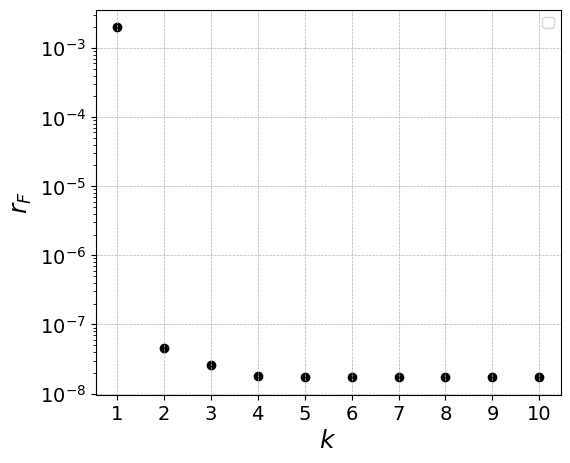

[3.578e-04 2.706e-04 2.224e-17 2.266e-16 2.394e-17 2.568e-17 2.441e-17
 2.705e-17 2.989e-17 3.622e-14]
(np.float64(-0.4999999999999999), np.float64(1.0), np.float64(-0.4999999999999999))
[∂t ∂α ∂β ρ, ρ[v_α · v_β], ∂α ∂γ ρ[v_β · v_γ], ∂γ² ρ[v_α · v_β], ∂α ∂β ρ[v_γ · v_γ]]
-0.5 · ∂γ² ρ[v_α · v_β] + ∂α ∂γ ρ[v_β · v_γ] + -0.5 · ∂α ∂β ρ[v_γ · v_γ] = 0


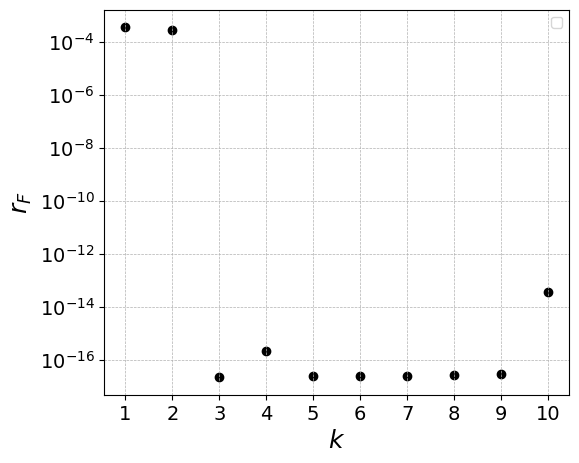

In [35]:
import numpy as np
import matplotlib.pyplot as plt
for i, res in enumerate(reg_results):
    if len(eqs[i].terms)>1:
        all_lambdas = res.all_lambdas
        print(all_lambdas)
        all_xis = res.all_xis
        xi_values = res.xi
        sublibrary_terms = res.sublibrary
        equations = []
        print(eqs[i].coeffs)
        print([t for (t, c) in zip(res.sublibrary, res.all_xis[4]) if c!=0])
        #equation_terms = [f"{xi:.1e} {term}" for xi, term in zip(xi_values, sublibrary_terms) if abs(xi) > 1e-15]
        #equation_string = " + ".join(equation_terms)
        equation_string = str(eqs[i].pstr(**{'num_format': '{0:.3g}', 'latex_output': False}))
        print(equation_string)
    
        
        plt.figure(figsize=(6, 5))
        #plt.scatter(range(2, len(all_lambdas) + 1), all_lambdas[1:], color='k')#, label="Lambda values") # range(1, 
        max_terms = min(10, len(all_lambdas))
        plt.scatter(range(1, max_terms+1), all_lambdas[:10], color='k')#, label="Lambda values")

        
        # Set log scale for y-axis
        plt.yscale("log")

        fs = 18
        fs2 = 14
        plt.xlabel("$k$", fontsize=fs)
        plt.ylabel("$r_F$", fontsize=fs)
        #plt.title(f"Equation: {equation_string}")  # Use the computed equation as the title
        #plt.xticks(range(2, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations
        plt.xticks(range(1, max_terms+1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations

        plt.yticks(fontsize=fs2)
        plt.legend()
        plt.grid(True, linestyle="--", linewidth=0.5) # which="both"

        name = f'discrete_pareto_{i}.eps'
        #plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300, 
        plt.show()

In [12]:
for k, v in excluded_terms.items():
    print(len(v), v)

21 {∂t ρ · ∂t² ρ, ∂t ρ, ∂t ρ · ρ[v_α · v_α], ∂t² ∂α² ρ, ∂t ∂α ρ · ρ[v_α], ρ · ∂t ρ · ∂t ρ, ρ · ρ · ∂t ρ, ρ · ∂t² ρ, ∂t² ρ, ∂α ρ · ∂t ∂α ρ, ∂t ρ · ∂α ρ[v_α], ρ · ρ · ρ · ∂t ρ, ∂t⁴ ρ, ∂t ρ · ∂t ρ, ρ · ∂t³ ρ, ρ · ρ · ∂t² ρ, ρ · ∂t ∂α² ρ, ∂α² ρ · ∂t ρ, ρ · ∂t ρ, ∂t³ ρ, ∂t ∂α² ρ}
15 {∂t² ρ · ρ[v_α], ρ · ∂α ρ · ∂t ρ, ∂t ρ · ∂t ρ[v_α], ∂t ρ · ∂t ∂α ρ, ∂t ρ · ρ[v_α], ρ · ∂t ∂α ρ, ρ · ∂t ρ · ρ[v_α], ∂t² ∂α ρ, ∂α ρ · ∂t ρ, ∂α ρ · ∂t² ρ, ∂t ∂α ρ, ∂t ∂α ∂β² ρ, ρ · ∂t² ∂α ρ, ∂t³ ∂α ρ, ρ · ρ · ∂t ∂α ρ}
8 {∂t ρ · ∂α ρ[v_β], ρ · ∂t ∂α ∂β ρ, ∂t ρ · ρ[v_α · v_β], ∂t² ∂α ∂β ρ, ∂t ∂α ∂β ρ, ∂α ρ · ∂t ∂β ρ, ∂t ∂α ρ · ρ[v_β], ∂α ∂β ρ · ∂t ρ}
19 {∂t ∂α ρ[v_β], ρ · ∂t ∂α ρ[v_β], ∂α ρ · ∂t ∂β ρ, ρ · ∂t ρ[v_α · v_β], ∂t ρ[v_α · v_β], ∂t ρ · ∂α ρ[v_β], ∂t² ∂α ρ[v_β], ρ[v_α] · ∂t ρ[v_β], ∂α ∂β ρ · ∂t ρ, ρ · ∂t ∂α ∂β ρ, ∂t ρ · ρ[v_α · v_β], ρ[v_α] · ρ[v_β], ∂t ∂α ∂β ρ, ∂α ρ · ∂t ρ[v_β], ∂t² ρ[v_α · v_β], ∂t ∂α ρ · ρ[v_β], ∂γ² ρ[v_α · v_β], ∂t² ∂α ∂β ρ, ρ · ρ[v_α] · ρ[v_β]}


In [13]:
# from commons.identify_models import *
# import copy

# #srd = load('Q_gauss1024.npy', 1)
# libs = srd.libs

# reg_opts_list = []
# for irrep in srd.irreps:
#     #print(np.linalg.norm(libs[irrep].Q, axis=0))
#     # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
#     scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=1)
#     #init = Initializer(method='combinatorial', start_k=3)
#     #init = Initializer(method='combinatorial', start_k=9999)
#     init = Initializer(method='power', start_k=10)
#     #res = Residual(residual_type='fixed_column', anchor_col=0)
#     #res = Residual(residual_type='dominant_balance')
#     res = Residual(residual_type='hybrid')
    
#     iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=10)
#     #iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
#     thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#     #thres = Threshold(threshold_type='information', ic=AIC)
    
#     opts = {'scaler': scaler, 'initializer': init, 'residual': res,
#             'model_iterator': iterator, 'threshold': thres}
#     opts['verbose'] = False
#     opts['inhomog'] = False
#     opts['inhomog_col'] = None
#     reg_opts_list.append(opts)

# eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
# #reg_opts_list, threshold=2e-2, experimental=True)
# reg_opts_list, threshold=4e-2, experimental=True)

In [14]:
print(srd.scale_dict)
for irrep in srd.irreps:
    # don't forget preprocessing
    Q = srd.libs[irrep].Q/srd.libs[irrep].col_weights # reweight columns
    for i in range(Q.shape[0]): # normalize rows
        Q[i, :] /= np.linalg.norm(Q[i, :])
    [U, S, V] = np.linalg.svd(Q)
    print(np.linalg.norm(Q)/max(S))

{'v': {'mean': np.float64(0.01644200831703069), 'std': np.float64(0.016442008317030705)}, 'rho': {'mean': np.float64(1.0), 'std': np.float64(0.6411404021051048)}}
1.0990660933194663
1.3066594097967368
1.0695425460154058
1.181063404770827


In [33]:
lib1 = libs[srd.irreps[1]]
for i, term, size in zip(list(range(len(lib1.terms))), lib1.terms, lib1.col_weights):
    print(i, term, size, np.linalg.norm(lib1.Q[:, i])/size, term.complexity)
# print(next(regex_find(lib1.terms, r'∂α ∂β² ρ')))
# print(next(regex_find(lib1.terms, r'∂t ρ\[v_α\]')))
# print(next(regex_find(lib1.terms, r'∂β ρ\[v_α · v_β\]')))
# print(next(regex_find(lib1.terms, r'∂α ρ\[v_β · v_β\]')))
# print(next(regex_find(lib1.terms, r'∂α ρ')))

0 ρ · ∂α ρ 0.03205702010525524 58585.00336254374 3
1 ρ · ∂α ∂β² ρ 8.014255026313811e-05 968541.9598756516 5
2 ρ · ∂t ∂α ρ 6.411404021051048e-05 53399.429280836375 4
3 ρ · ∂t² ∂α ρ 1.2822808042102096e-07 240474.82457113793 5
4 ρ · ρ[v_α] 0.01644200831703069 6298.243691370336 3
5 ρ · ∂α ∂β ρ[v_β] 2.635408955949136e-05 129907.08585751876 5
6 ρ · ∂β² ρ[v_α] 2.635408955949136e-05 161070.04693356945 5
7 ρ · ∂t ρ[v_α] 2.1083271647593086e-05 34489.29807194921 4
8 ρ · ∂t² ρ[v_α] 4.216654329518618e-08 217457.59688124727 5
9 ρ · ∂α ρ[v_β · v_β] 8.666283194498579e-06 127986.61288980918 5
10 ρ · ∂β ρ[v_α · v_β] 8.666283194498579e-06 73819.28609085805 5
11 ρ · ρ[v_α · v_β · v_β] 4.444926568153775e-06 29308.120155191045 5
12 ∂α ρ 0.03205702010525524 50120.36179407675 2
13 ∂β ρ · ∂α ∂β ρ 5.1382626901436934e-05 187614.17520822588 5
14 ∂α ρ · ∂β² ρ 5.1382626901436934e-05 260419.22887109086 5
15 ∂α ρ · ∂t ρ 4.110610152114955e-05 10861.750883901532 4
16 ∂α ρ · ∂t² ρ 8.22122030422991e-08 70174.68746832757 

In [34]:
lib0 = libs[srd.irreps[0]]
for i, term, size in zip(list(range(len(lib0.terms))), lib0.terms, lib0.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib0.terms, r'∂α² ρ')))
print(next(regex_find(lib0.terms, r'∂t² ρ')))
print(next(regex_find(lib0.terms, r'ρ')))
print(next(regex_find(lib0.terms, r'ρ\[v_α · v_α\]')))
print(next(regex_find(lib0.terms, r'ρ · ρ')))
print(next(regex_find(lib0.terms, r'ρ · ρ\[v_α · v_α\]')))

0 ρ 1.0 1
1 ρ · ρ 1.0 2
2 ρ · ∂α² ρ 0.001602851005262762 4
3 ρ · ∂t ρ 0.0012822808042102097 3
4 ρ · ∂t ∂α² ρ 3.205702010525524e-06 5
5 ρ · ∂t² ρ 2.5645616084204193e-06 4
6 ρ · ∂t³ ρ 5.1291232168408385e-09 5
7 ρ · ∂α ρ[v_α] 0.0005270817911898272 4
8 ρ · ∂t ∂α ρ[v_α] 1.0541635823796544e-06 5
9 ρ · ρ[v_α · v_α] 0.00027033963749730644 4
10 ρ · ∂t ρ[v_α · v_α] 3.4665132777994317e-07 5
11 ∂α ρ · ∂α ρ 0.0010276525380287387 4
12 ∂α ρ · ∂t ∂α ρ 2.0553050760574774e-06 5
13 ∂α ρ · ρ[v_α] 0.0005270817911898268 4
14 ∂α ρ · ∂t ρ[v_α] 6.758668630914493e-07 5
15 ∂α² ρ 0.001602851005262762 3
16 ∂α² ρ · ∂t ρ 2.0553050760574774e-06 5
17 ∂α² ∂β² ρ 4.007127513156905e-06 5
18 ∂t ρ 0.0012822808042102097 2
19 ∂t ρ · ∂t ρ 1.644244060845982e-06 4
20 ∂t ρ · ∂t² ρ 3.2884881216919644e-09 5
21 ∂t ρ · ∂α ρ[v_α] 6.758668630914494e-07 5
22 ∂t ρ · ρ[v_α · v_α] 3.4665132777994264e-07 5
23 ∂t ∂α ρ · ρ[v_α] 1.0541635823796533e-06 5
24 ∂t ∂α² ρ 3.205702010525524e-06 4
25 ∂t² ρ 2.5645616084204193e-06 3
26 ∂t² ∂α² ρ 6.411404

In [17]:
col_norms = np.linalg.norm(lib0.Q/lib0.col_weights, axis=0)
print(len(col_norms), lib0.Q.shape)
for term, norm in zip(lib0.terms, col_norms/max(col_norms)):
    print(term, norm)

42 (240, 42)
ρ 0.008178033918017137
ρ · ρ 0.014139861184567204
ρ · ∂α² ρ 0.0644811532581539
ρ · ∂t ρ 8.475002404784028e-07
ρ · ∂t ∂α² ρ 2.6349044323879092e-05
ρ · ∂t² ρ 2.157986116832892e-09
ρ · ∂t³ ρ 7.0916643956325666e-12
ρ · ∂α ρ[v_α] 0.005154398186709863
ρ · ∂t ∂α ρ[v_α] 1.3124415410163516e-05
ρ · ρ[v_α · v_α] 0.028138190692251413
ρ · ∂t ρ[v_α · v_α] 6.3768649759449334e-06
∂α ρ · ∂α ρ 0.042860486385259286
∂α ρ · ∂t ∂α ρ 5.0020293973336526e-06
∂α ρ · ρ[v_α] 0.001637624570746333
∂α ρ · ∂t ρ[v_α] 3.1180835606653303e-06
∂α² ρ 0.03747493683907799
∂α² ρ · ∂t ρ 4.146319469876682e-06
∂α² ∂β² ρ 1.0
∂t ρ 5.229396743857226e-07
∂t ρ · ∂t ρ 3.4924372981591467e-10
∂t ρ · ∂t² ρ 1.8819385737195666e-13
∂t ρ · ∂α ρ[v_α] 2.123790450129051e-06
∂t ρ · ρ[v_α · v_α] 1.7713311164451496e-06
∂t ∂α ρ · ρ[v_α] 1.3735891947069172e-06
∂t ∂α² ρ 1.6236017833337226e-05
∂t² ρ 1.3015462657138024e-09
∂t² ∂α² ρ 4.530956378753425e-08
∂t³ ρ 4.057681770041507e-12
∂t⁴ ρ 1.974088002490654e-14
ρ[v_α] · ρ[v_α] 0.000440623102

In [18]:
# test specific relation for r_h: dt rho[v_alpha], d_alpha rho
lt = lib1.terms
#print(f'{lt[12]}, {lt[39]}')
#scaler = Scaler(sub_inds=[12, 39], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
print(f'{lt[33]}, {lt[48]}')
scaler = Scaler(sub_inds=[33, 48], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

ρ[v_α], ρ[v_α · v_β · v_β]
0.11915748404859196 [-0.002  1.   ]


In [19]:
lt = lib0.terms
print(f'{lt[15]}, {lt[25]}')
scaler = Scaler(sub_inds=[15, 25], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib0.Q, None, scaler, return_xi=True)
print(rh, xi)

∂α² ρ, ∂t² ρ
2.368269843888546e-07 [-4.122e-04  1.000e+00]


In [20]:
np.linalg.norm(lib1.Q[:, 12]), lib1.col_weights[12]

(np.float64(1606.709445715385), np.float64(0.03205702010525524))

In [21]:
# test specific relation for r_h: rho, rho[v_alpha * v_alpha]
scaler = Scaler(sub_inds=[0, 35], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib0.Q, None, scaler, return_xi=True)
print(rh, xi)

0.10869455974720935 [-5.478e-04  1.000e+00]


In [22]:
# ostrichified
scaler = Scaler(sub_inds=[0, 35, 1, 9], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh = hybrid_residual(lib0.Q, None, scaler)
print(rh)

0.016443268537889213


In [23]:
#(24, ∂α ∂β² ρ)
#(39, ∂t ρ[v_α])
#(45, ∂β ρ[v_α · v_β])
#(44, ∂α ρ[v_β · v_β])
#(12, ∂α ρ)
lt = lib1.terms
print(f'{lt[12]}, {lt[24]}, {lt[39]}, {lt[45]}')
scaler = Scaler(sub_inds=[12, 24, 39, 45], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

∂α ρ, ∂α ∂β² ρ, ∂t ρ[v_α], ∂β ρ[v_α · v_β]
3.140402398132584e-05 [-1.987e-04 -8.726e-04  7.155e-01  1.000e+00]


In [24]:
scaler = Scaler(sub_inds=[24, 39, 44, 45], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh = hybrid_residual(lib1.Q, None, scaler)
print(rh)

3.166350436959592e-05


In [25]:
lib0 = libs[srd.irreps[0]]
scaler = Scaler(sub_inds=None, char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
#init = Initializer(method='combinatorial', start_k=3)
#init = Initializer(method='combinatorial', start_k=9999)
init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(libs0.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
#opts['inhomog_col'] = 1 # ρ²
opts['inhomog_col'] = 15 # ∂α² ρ
#opts['inhomog_col'] = 25 # ∂t² ρ

remove_terms = [34, 2] # ∂t ∂α ρ[v_α], ρ · ∂α² ρ
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib0.Q, **opts)
zipped = [(lib0.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)
rh = hybrid_residual(lib0.Q, reg_result.xi, opts['scaler'])
print(f'(r_h = {rh:.2e})')

∂α² ρ = 0 ; residual: 0.03588263011401875
(r_h = 1.00e+00)


In [26]:
lib1 = libs[srd.irreps[1]]
scaler = Scaler(sub_inds=None, char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=3)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(lib1.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 39 # dt rho[v_i]
opts['verbose'] = False

remove_terms = [7] # rho * dt rho[v_i]
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib1.Q, **opts)
zipped = [(lib1.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)
rh = hybrid_residual(lib1.Q, reg_result.xi, opts['scaler'])
print(f'(r_h = {rh:.2e})')

0.10907528042083064 · ∂t ρ[v_α] + ∂t ∂β² ρ[v_α] = 0 ; residual: 1.1879714060283002e-05
(r_h = 1.68e-02)


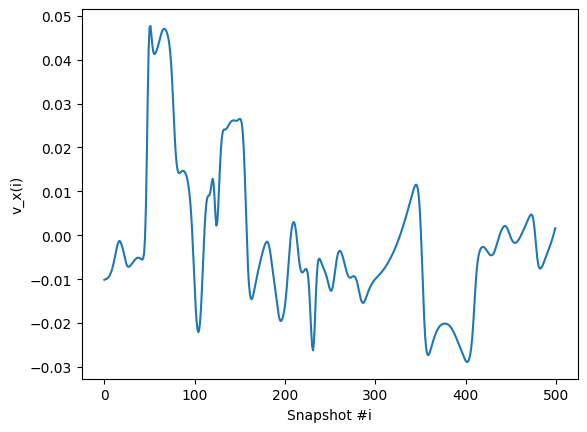

In [51]:
plt.plot(vs[1, 0, :500])
plt.xlabel('Snapshot #i')
plt.ylabel('v_x(i)')
#plt.title('vs[0, 0, :] vs Time')
plt.show()

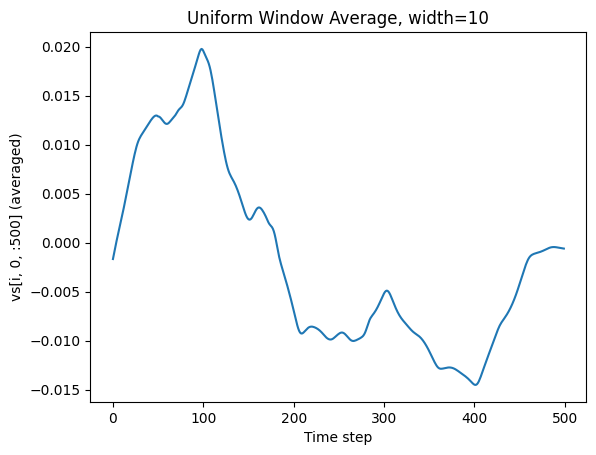

In [53]:
# Apply uniform window kernel averaging with width 10
window_size = 100
kernel = np.ones(window_size) / window_size
vs_smoothed = np.convolve(vs[1, 0, :500], kernel, mode='same')

plt.plot(vs_smoothed)
plt.xlabel('Time step')
plt.ylabel('vs[i, 0, :500] (averaged)')
plt.title('Uniform Window Average, width=10')
plt.show()


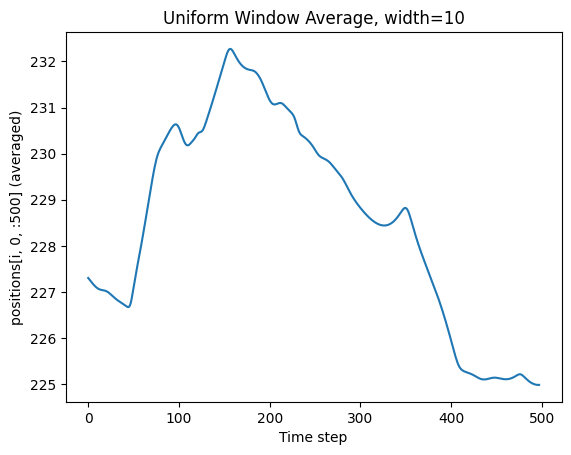

In [57]:
# Apply uniform window kernel averaging with width 10
window_size = 1
kernel = np.ones(window_size) / window_size
p_smoothed = np.convolve(positions[1, 0, :500], kernel, mode='same')

plt.plot(p_smoothed[window_size:500-window_size])
plt.xlabel('Time step')
plt.ylabel('positions[i, 0, :500] (averaged)')
plt.title('Uniform Window Average, width=10')
plt.show()